In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

from unet import UNetModel
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

## Load Data

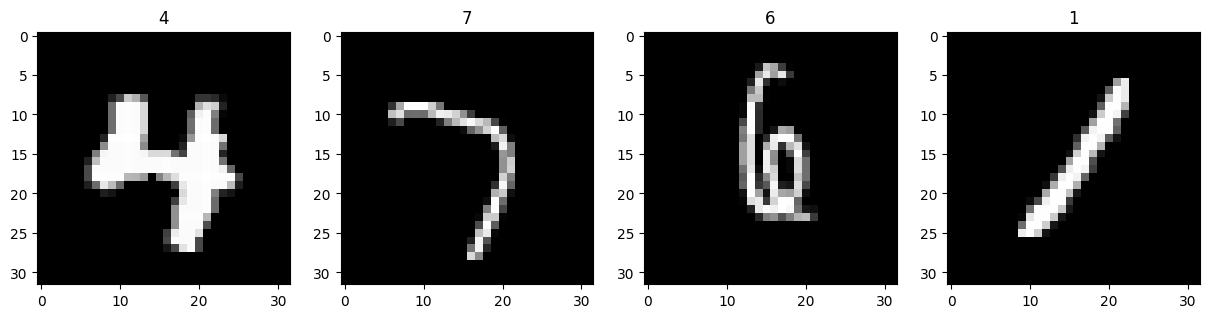

In [ ]:
# Load MNIST dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Pad(2),
    torchvision.transforms.Normalize(0.5, 0.5),
])
mnist_train = torchvision.datasets.MNIST(root='data/', train=True, transform=transforms, download=True)
data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

for batch in data_loader:
    img, labels = batch
    break

fig, ax = plt.subplots(1, 4, figsize=(15,15))
for i in range(4):
    ax[i].imshow(img[i,0,:,:].numpy())
    ax[i].set_title(str(labels[i].item()))
plt.show()

## Load Model

In [ ]:
# Save/Load model
#torch.save(net.state_dict(), 'models/mnist_unet.pth')
#print('Saved model')

net = UNetModel(image_size=32, in_channels=1, out_channels=1,
                model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[8,4], num_heads=4).to(device)
net.load_state_dict(torch.load('mnist_unet.pth', map_location=torch.device('cpu')))

net.to(device)
net.train()
print('Loaded model')

Loaded model


## Inference with hand-crafted conditions

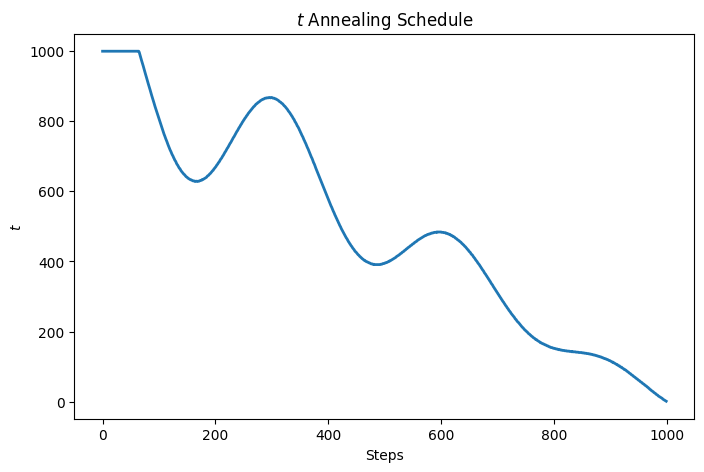

In [ ]:
# Visualize t annealing schedule
diffusion = GaussianDiffusion(T=1000, schedule='linear')
steps = 1000

t_vals = []
for i in range(steps):
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)
    t_vals.append(t[0])

plt.figure(figsize=(8,5))
plt.plot(range(steps), t_vals, linewidth=2)
plt.title('$t$ Annealing Schedule')
plt.xlabel('Steps')
plt.ylabel('$t$')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s, Loss=0.985]

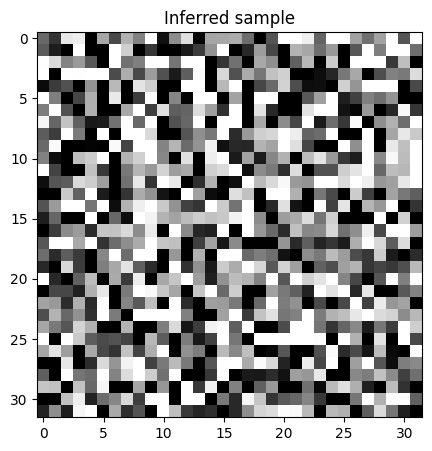

 10%|▉         | 99/1000 [00:41<05:44,  2.62it/s, Loss=0.976]

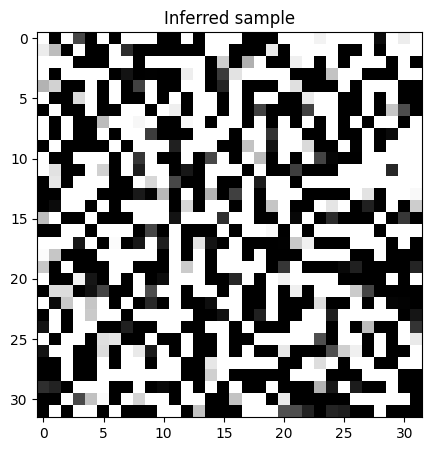

 20%|█▉        | 199/1000 [01:19<04:50,  2.76it/s, Loss=0.977]

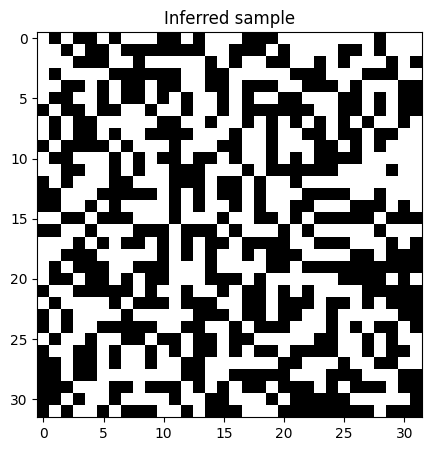

 30%|██▉       | 299/1000 [01:58<04:12,  2.77it/s, Loss=0.974]

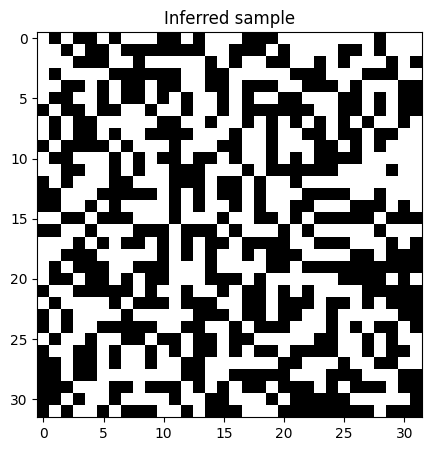

 40%|███▉      | 399/1000 [02:36<03:33,  2.82it/s, Loss=0.975]

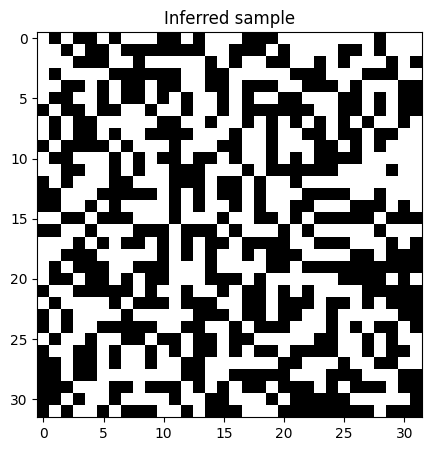

 50%|████▉     | 499/1000 [03:15<03:13,  2.59it/s, Loss=0.966]

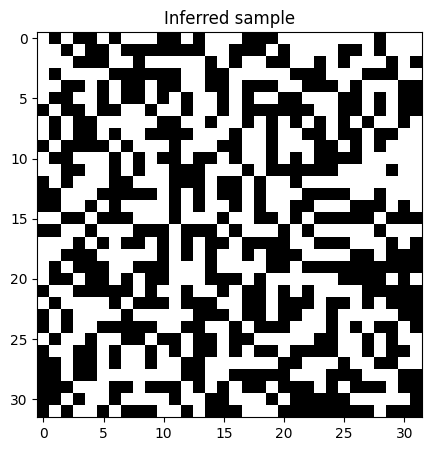

 60%|█████▉    | 599/1000 [03:53<02:24,  2.78it/s, Loss=0.986]

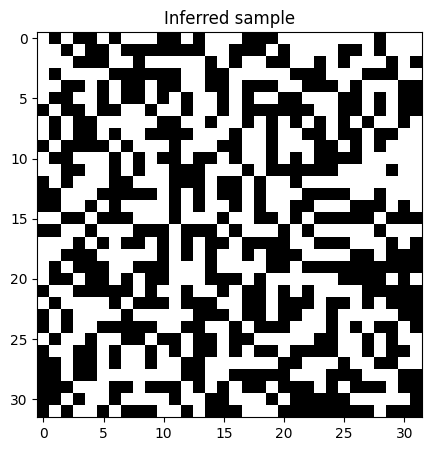

 70%|██████▉   | 699/1000 [04:31<01:48,  2.78it/s, Loss=0.985]

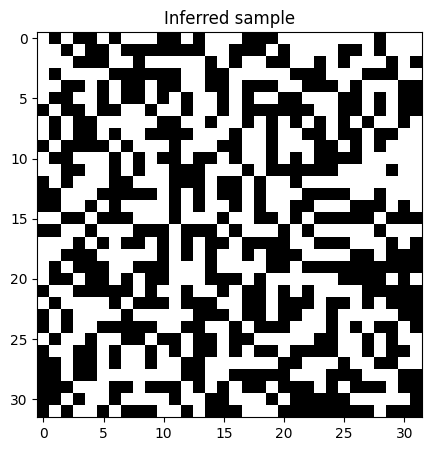

 80%|███████▉  | 799/1000 [05:09<01:10,  2.84it/s, Loss=0.985]

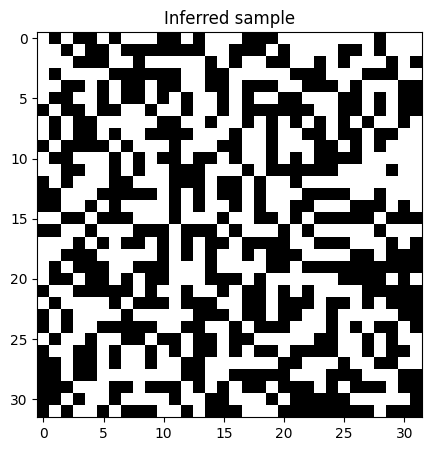

 90%|████████▉ | 899/1000 [05:48<00:35,  2.84it/s, Loss=0.997]

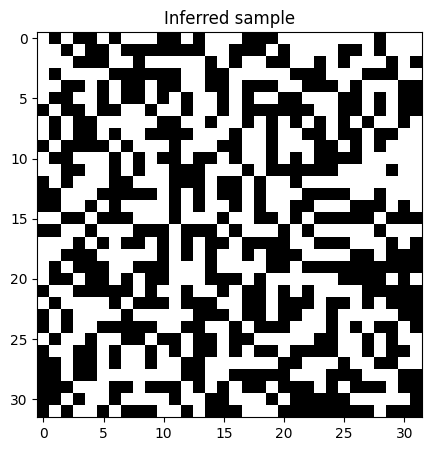

100%|█████████▉| 999/1000 [06:26<00:00,  2.81it/s, Loss=0.999]

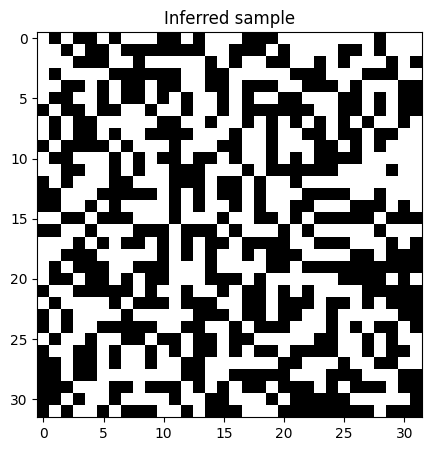

100%|██████████| 1000/1000 [06:26<00:00,  2.58it/s, Loss=0.999]


In [ ]:
# Inference Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.img = nn.Parameter(torch.randn(1,1,32,32))
        self.img.requires_grad = True

    def encode(self):
        return self.img

model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
net.train()

steps = 1000
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
for i, _ in enumerate(bar):
    sample_img = model.encode()

    # Select t
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)

    # Denoise
    xt, epsilon = diffusion.sample(sample_img, t)
    t = torch.from_numpy(t).float().view(sample_img.shape[0])
    epsilon_pred = net(xt.float(), t.to(device))

    # Hand-crafted conditions
    sample_img_clipped = torch.clip(sample_img, -1, 1)
    #vertical_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(model.encode()))
    #horizontal_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(model.encode()))
    #vertical_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(sample_img_clipped))
    horizontal_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(sample_img_clipped))

    # Denoising loss + aux loss
    loss = F.mse_loss(epsilon_pred, epsilon) + 0.01*(steps-i)/steps*horizontal_dissimilarity

    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(model.encode()[0].detach().cpu().numpy().transpose([1,2,0]), vmin=-1, vmax=1)
            ax.set_title('Inferred sample')
            plt.show()

## Inference with a learned condition

Epoch [1/5]


100%|██████████| 469/469 [00:31<00:00, 14.94it/s, Loss=0.165]


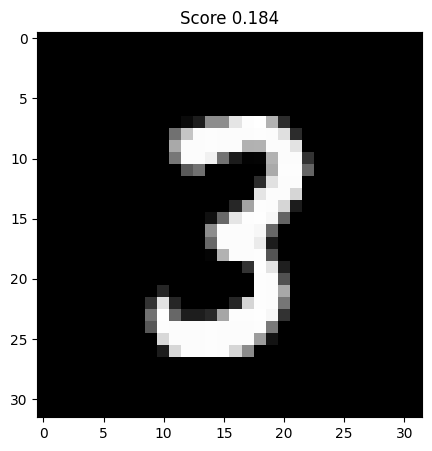

Epoch [2/5]


100%|██████████| 469/469 [00:30<00:00, 15.39it/s, Loss=0.0951]


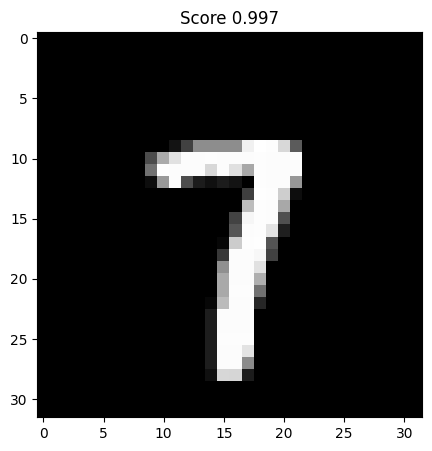

Epoch [3/5]


100%|██████████| 469/469 [00:30<00:00, 15.40it/s, Loss=0.075]


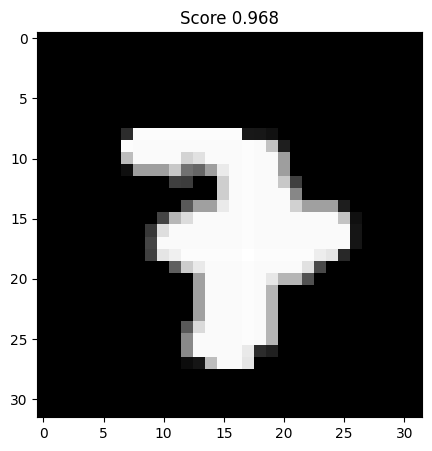

Epoch [4/5]


100%|██████████| 469/469 [00:31<00:00, 14.82it/s, Loss=0.0717]


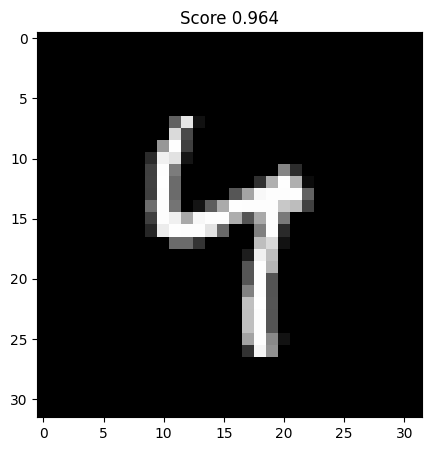

Epoch [5/5]


100%|██████████| 469/469 [00:30<00:00, 15.36it/s, Loss=0.0629]


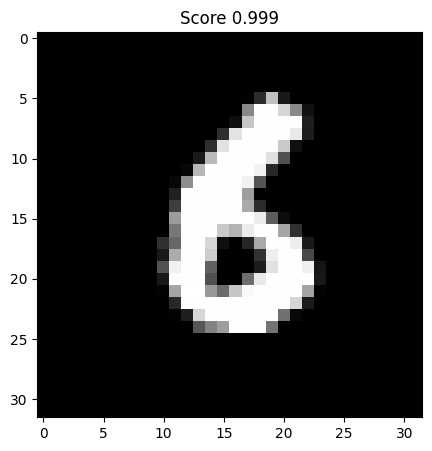

In [ ]:
# Train classifier
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 2, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 2, 1)
        self.out = nn.Linear(4*4*32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.out(x.flatten(1))

        return torch.sigmoid(x)

# Train network
class_net = Classifier().to(device)
class_opt = torch.optim.Adam(class_net.parameters(), lr=1e-4)

target_label = 3 # Digit to distinguish
epochs = 5
update_every = 100
for e in range(epochs):
    print(f'Epoch [{e+1}/{epochs}]')

    losses = []
    batch_bar = tqdm.tqdm(data_loader)
    for i, batch in enumerate(batch_bar):
        img, labels = batch

        labels = (labels != target_label).float().to(device)

        # Pass through network
        out = class_net(img.float().to(device))

        # Compute loss and backprop
        loss = F.binary_cross_entropy(out.squeeze(-1), labels)

        class_opt.zero_grad()
        loss.backward()
        class_opt.step()

        losses.append(loss.item())
        if i % update_every == 0:
            batch_bar.set_postfix({'Loss': np.mean(losses)})
            losses = []

    batch_bar.set_postfix({'Loss': np.mean(losses)})
    losses = []

    plt.figure(figsize=(5,5))
    plt.imshow(img.numpy()[0,0,:,:])
    plt.title(f'Score {out[0].item():.3f}')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s, Loss=1.04]

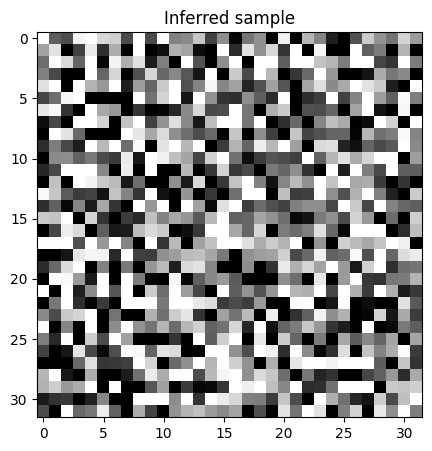

 10%|▉         | 99/1000 [00:38<05:26,  2.76it/s, Loss=1.01]

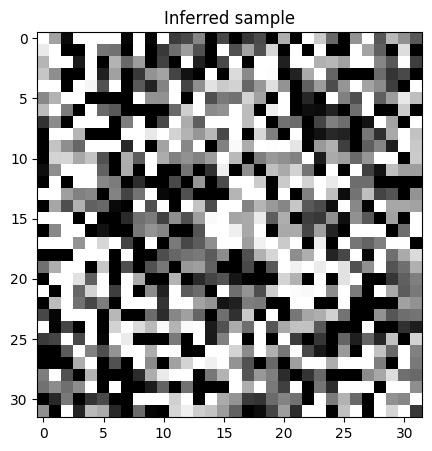

 20%|█▉        | 199/1000 [01:17<04:41,  2.84it/s, Loss=0.997]

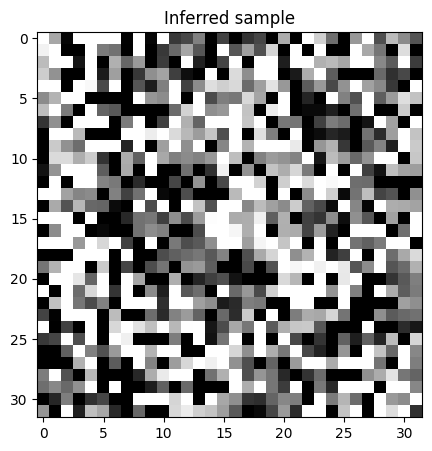

 30%|██▉       | 299/1000 [01:55<04:07,  2.83it/s, Loss=0.994]

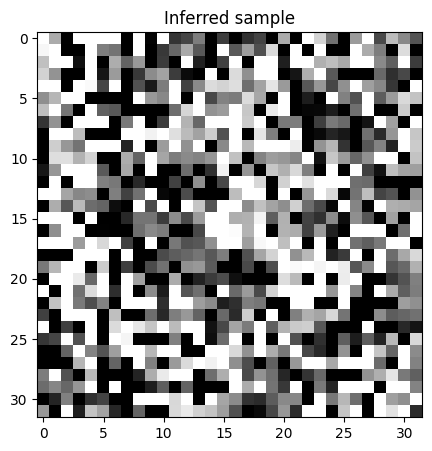

 40%|███▉      | 399/1000 [02:34<03:32,  2.83it/s, Loss=1.01]

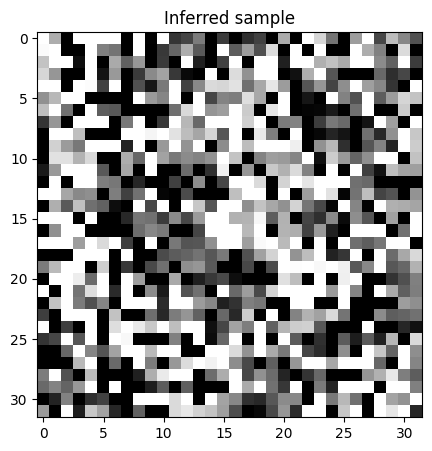

 50%|████▉     | 499/1000 [03:12<02:56,  2.83it/s, Loss=0.996]

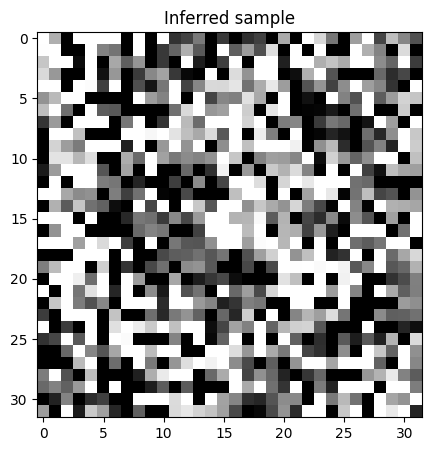

 60%|█████▉    | 599/1000 [03:51<02:21,  2.82it/s, Loss=0.996]

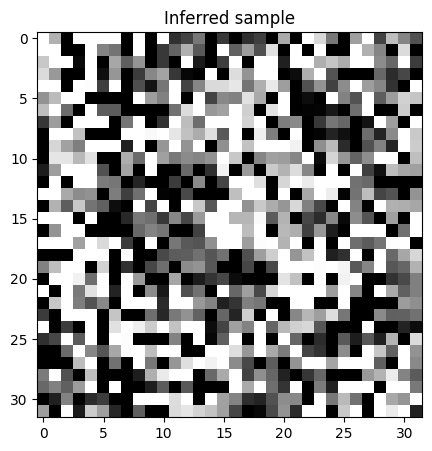

 70%|██████▉   | 699/1000 [04:30<01:49,  2.76it/s, Loss=1]

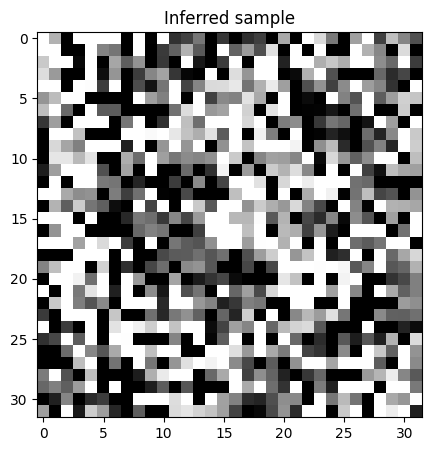

 80%|███████▉  | 799/1000 [05:09<01:13,  2.73it/s, Loss=1.01]

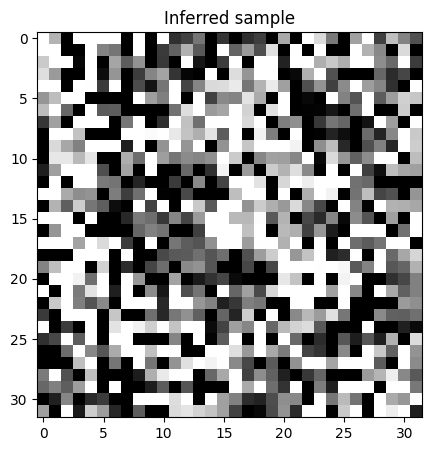

 90%|████████▉ | 899/1000 [05:49<00:47,  2.11it/s, Loss=1]

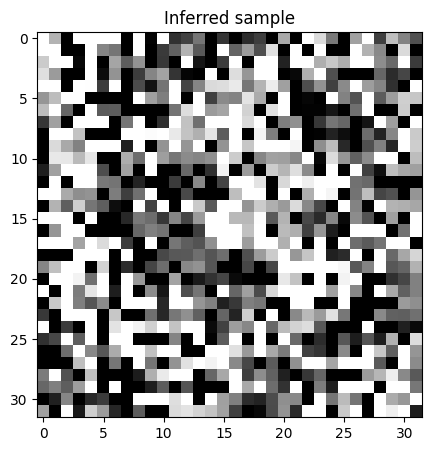

100%|█████████▉| 999/1000 [06:28<00:00,  1.91it/s, Loss=0.991]

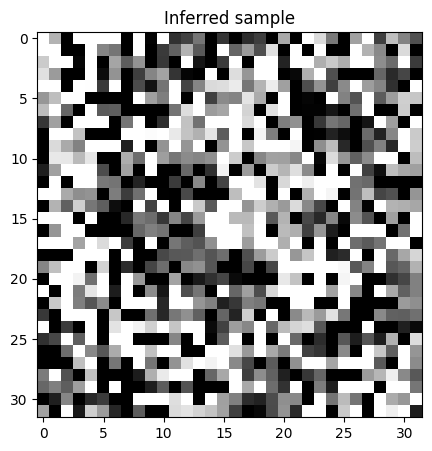

100%|██████████| 1000/1000 [06:28<00:00,  2.57it/s, Loss=0.991]


In [ ]:
# Inference Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.img = nn.Parameter(torch.randn(1,1,32,32))
        self.img.requires_grad = True

    def encode(self):
        return self.img

model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
net.train()
class_net.train()

steps = 1000
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
for i, _ in enumerate(bar):
    sample_img = model.encode()

    # Select t
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)

    # Denoise
    xt, epsilon = diffusion.sample(sample_img, t)
    t = torch.from_numpy(t).float().view(sample_img.shape[0])
    epsilon_pred = net(xt.float(), t.to(device))

    # Learned condition
    sample_img_clipped = torch.clip(sample_img, -1, 1)
    class_loss = class_net(sample_img_clipped).mean()

    # Denoising loss + aux loss
    loss = F.mse_loss(epsilon_pred, epsilon) + 0.01*(steps-i)/steps*class_loss

    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(model.encode()[0].detach().cpu().numpy().transpose([1,2,0]), vmin=-1, vmax=1)
            ax.set_title('Inferred sample')
            plt.show()

## Inference with hand-crafted and learned conditions

  0%|          | 0/1000 [00:00<?, ?it/s, Loss=0.997]

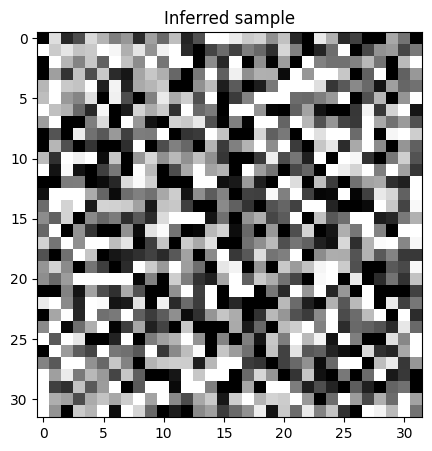

 10%|▉         | 99/1000 [00:38<07:37,  1.97it/s, Loss=1.02]

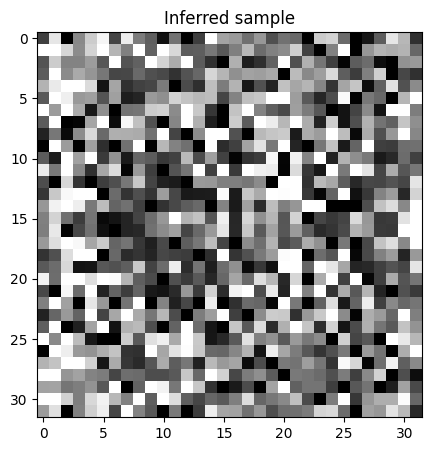

 20%|█▉        | 199/1000 [01:17<06:31,  2.05it/s, Loss=1.01]

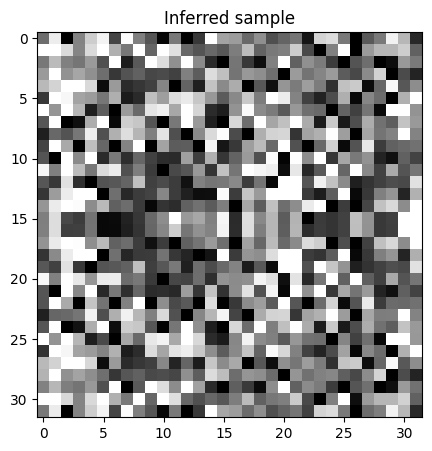

 30%|██▉       | 299/1000 [01:56<05:00,  2.33it/s, Loss=0.997]

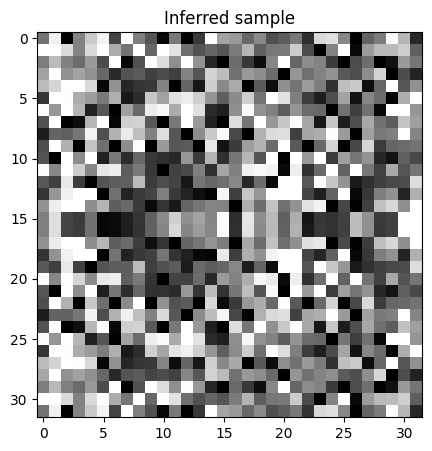

 40%|███▉      | 399/1000 [02:35<03:52,  2.58it/s, Loss=0.988]

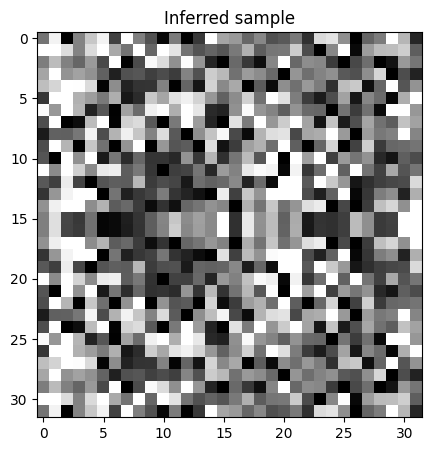

 50%|████▉     | 499/1000 [03:15<03:03,  2.72it/s, Loss=1.01]

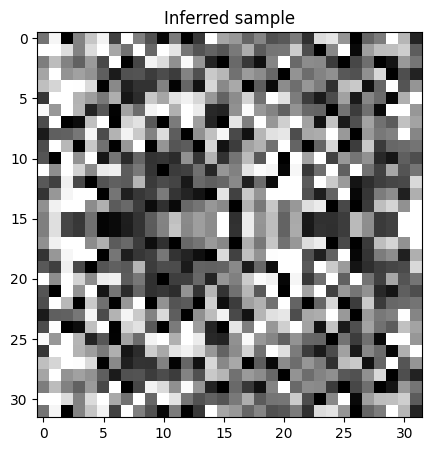

 60%|█████▉    | 599/1000 [03:54<02:26,  2.74it/s, Loss=0.997]

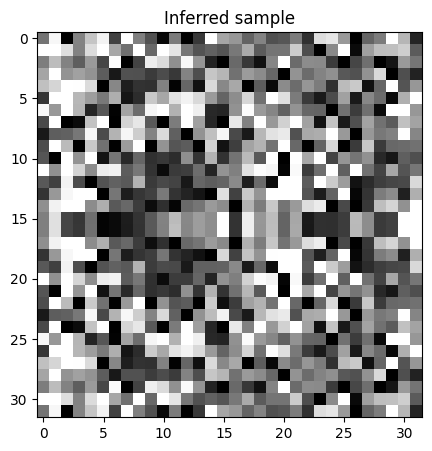

 70%|██████▉   | 699/1000 [04:33<01:47,  2.80it/s, Loss=1]

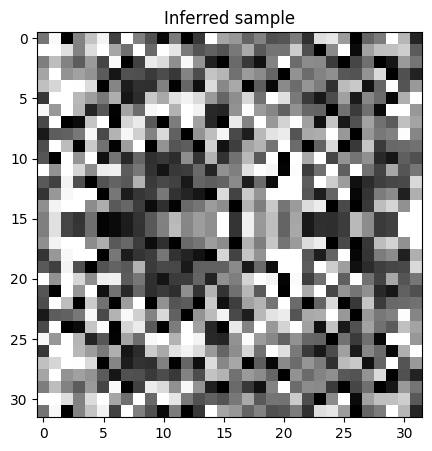

 80%|███████▉  | 799/1000 [05:12<01:12,  2.77it/s, Loss=0.994]

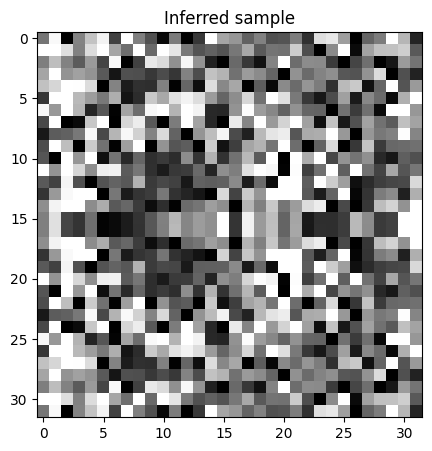

 90%|████████▉ | 899/1000 [05:50<00:36,  2.80it/s, Loss=1.01]

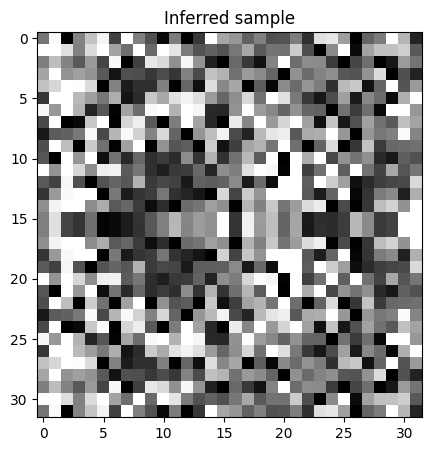

100%|█████████▉| 999/1000 [06:29<00:00,  2.77it/s, Loss=1]

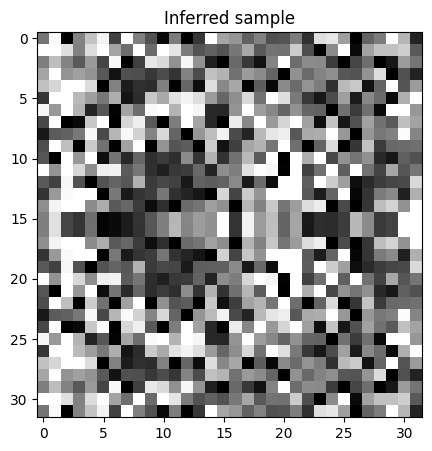

100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s, Loss=1]


In [ ]:
# Inference Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.img = nn.Parameter(torch.randn(1,1,32,32))
        self.img.requires_grad = True

    def encode(self):
        return self.img

model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
net.train()
class_net.train()

steps = 1000
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
for i, _ in enumerate(bar):
    sample_img = model.encode()

    # Select t
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)

    # Denoise
    xt, epsilon = diffusion.sample(sample_img, t)
    t = torch.from_numpy(t).float().view(sample_img.shape[0])
    epsilon_pred = net(xt.float(), t.to(device))

    # Conditions
    sample_img_clipped = torch.clip(sample_img, -1, 1)
    # Hand-crafted
    #vertical_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(model.encode()))
    horizontal_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(model.encode()))
    #vertical_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(sample_img_clipped))
    #horizontal_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(sample_img_clipped))
    # Learned
    class_loss = class_net(sample_img_clipped).mean()

    # Denoising loss + aux loss
    loss = F.mse_loss(epsilon_pred, epsilon) + 0.01*(steps-i)/steps*class_loss + 0.01*(steps-i)/steps*horizontal_similarity

    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(model.encode()[0].detach().cpu().numpy().transpose([1,2,0]), vmin=-1, vmax=1)
            ax.set_title('Inferred sample')
            plt.show()

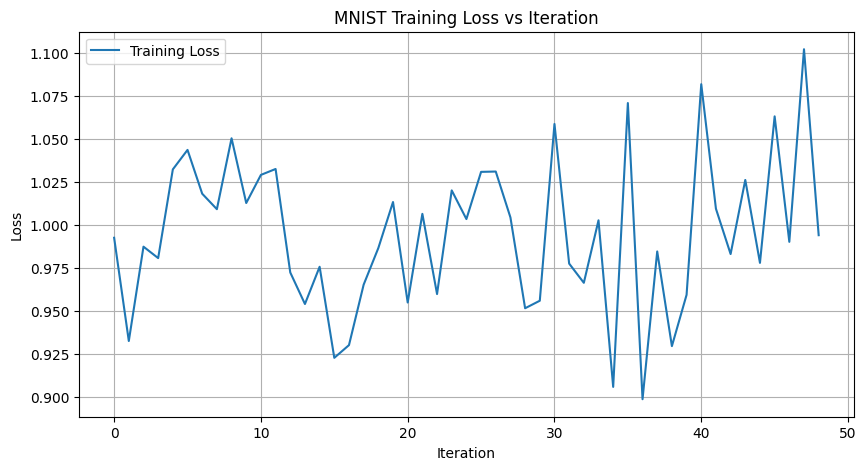

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MNIST Training Loss vs Iteration")
plt.legend()
plt.grid(True)
plt.show()
